In [3]:
import donkeycar as dk
import keras
import os
import numpy as np
import pandas as pd
from donkeycar import utils
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [16, 8]

Using TensorFlow backend.


In [8]:
def dataset_from_tub(tub_path, limit=500):
    tub = dk.parts.Tub(tub_path)
    idx = tub.get_index(shuffled=False)
    img_in = []
    angle_out = []
    throttle_out = []
    if limit==-1:
        limit = len(idx)

    for i in range(limit):
        rec = tub.get_record(idx[i])
        img_in.append(rec['cam/image_array'])
        angle_out.append(rec['user/angle'])
        throttle_out.append(rec['user/throttle'])
    return (np.array(img_in), np.array(angle_out), np.array(throttle_out))

def dataset_from_all_tubs(data_path):
    tub_paths = [os.path.join(data_path, n) for n in os.listdir(data_path)]
    datasets = [dataset_from_tub(p, limit=-1) for p in tub_paths]
    img_in = [ds[0] for ds in datasets]
    angle_out = [ds[1] for ds in datasets]
    throttle_out = [ds[2] for ds in datasets]
    return (np.concatenate(img_in), np.concatenate(angle_out), np.concatenate(throttle_out))

def bin_angle_out(angle_out):
    return np.array([dk.utils.linear_bin(o) for o in angle_out])

def output_pair_cat(model, dataset):
    img_in, angle_out, throttle_out = dataset
    angle_binned, throttle = model.predict(img_in)
    predicted = dk.utils.unbin_Y(angle_binned)
    return (predicted, angle_out)

def output_pair_lin(model, dataset):
    img_in, angle_out, throttle_out = dataset
    predicted, throttle = model.predict(img_in)
    return (predicted, angle_out)

def undistorted_ds(dataset):
    img_in = []
    for img in dataset[0]:
        img_in.append(undistort(img, balance=0.55)[9:79,:,:])
    
    return (np.asarray(img_in), dataset[1], dataset[2])

def mask_ds(dataset):
    mask_path = '../../donkeycar/d2/mask.png'
    mask = np.array(Image.open(mask_path))
    img_in = []
    for img in dataset[0]:
        img_in.append(utils.mask_image_array(img, mask))
    
    return (np.asarray(img_in), dataset[1], dataset[2])

import numpy as np
import os
import glob
import sys
import cv2


DIM=(1600, 1200)
K=np.array([[781.3524863867165, 0.0, 794.7118000552183], [0.0, 779.5071163774452, 561.3314451453386], [0.0, 0.0, 1.0]])
D=np.array([[-0.042595202508066574], [0.031307765215775184], [-0.04104704724832258], [0.015343014605793324]])

def undistort_maps(balance, w, h):
    assert w/h == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"

    scaled_K = K * w / DIM[0]
    scaled_K[2][2] = 1 # K[2][2] is always 1
    newmtx = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, (w,h), np.eye(3), balance=balance)
    return cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), newmtx, (w,h), cv2.CV_16SC2)

def undistort(img, map1, map2):
    return cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

Tub does exist


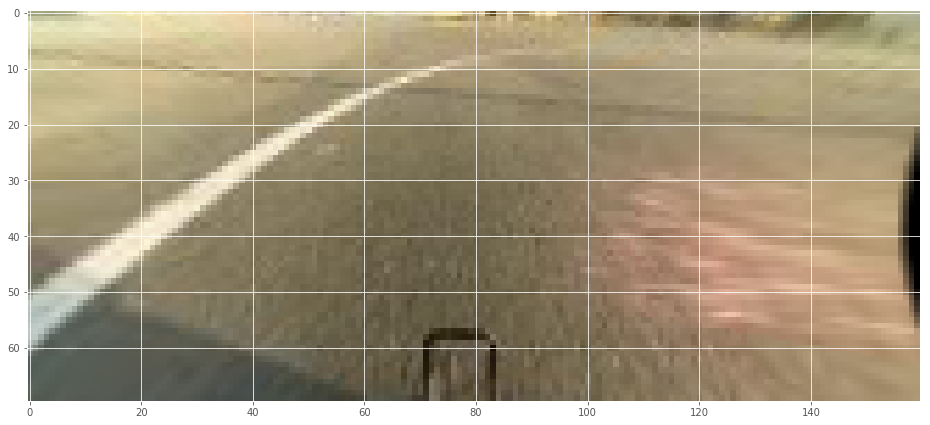

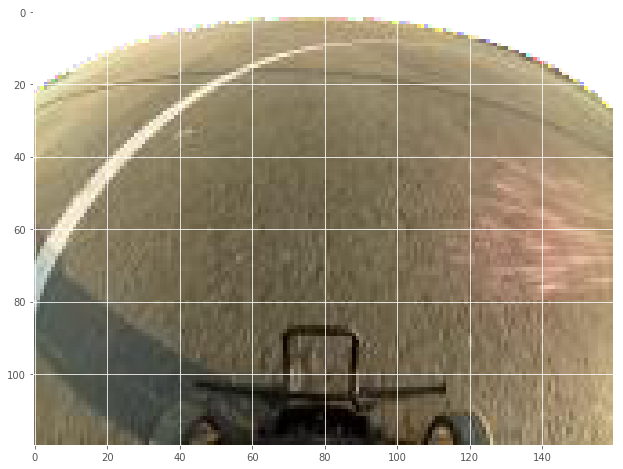

In [3]:
# dataset = dataset_from_all_tubs("../../donkeycar/d2/data")
dataset = dataset_from_tub("../../donkeycar/d2/data.ws.test/tub_notsogolden", limit=-1)
ds_70_160 = undistorted_ds(dataset)
plt.figure()
plt.imshow(ds_70_160[0][20])
masked_ds = mask_ds(dataset)
plt.figure()
plt.imshow(masked_ds[0][20])

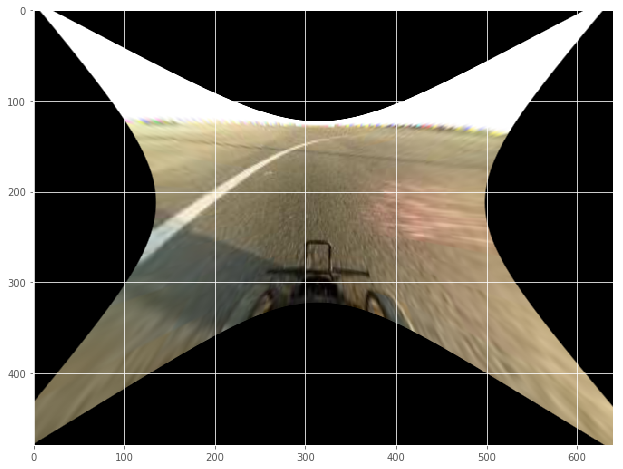

In [17]:
img = masked_ds[0][20]
img = cv2.resize(img, (0, 0), fx = 4, fy = 4, interpolation = cv2.INTER_LINEAR)
map1, map2 = undistort_maps(0.9,640,480)
img_out = undistort(img, map1, map2)
plt.imshow(img_out)

In [13]:
import numpy as np
import os
import glob
import sys
import cv2


DIM=(1600, 1200)
K=np.array([[781.3524863867165, 0.0, 794.7118000552183], [0.0, 779.5071163774452, 561.3314451453386], [0.0, 0.0, 1.0]])
D=np.array([[-0.042595202508066574], [0.031307765215775184], [-0.04104704724832258], [0.015343014605793324]])

def undistort_maps(img, balance):
    h,w = img.shape[:2]

    assert w/h == DIM[0]/DIM[1], "Image to undistort needs to have same aspect ratio as the ones used in calibration"

    scaled_K = K * w / DIM[0]
    scaled_K[2][2] = 1 # K[2][2] is always 1
    newmtx = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, (w,h), np.eye(3), balance=balance)
    return cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), newmtx, (w,h), cv2.CV_16SC2)

def undistort(img, balance=0.0):
    map1, map2 = undistort_maps(img, balance)
    return cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

# img = Image.open('../../donkeycar/d2/data/tub_44_17-09-15/154_cam-image_array_.jpg')
# img = img.resize((160*2, 120*2), resample=Image.LANCZOS)
img = Image.open('../../donkeycar/_15degree1.jpg')
img = np.array(img)
# img = undistort(img, balance=0.97)
img = undistort(img, balance=0.55)
cv2.imwrite("../../donkeycar/_15degree1_undistort.jpg", img)

True

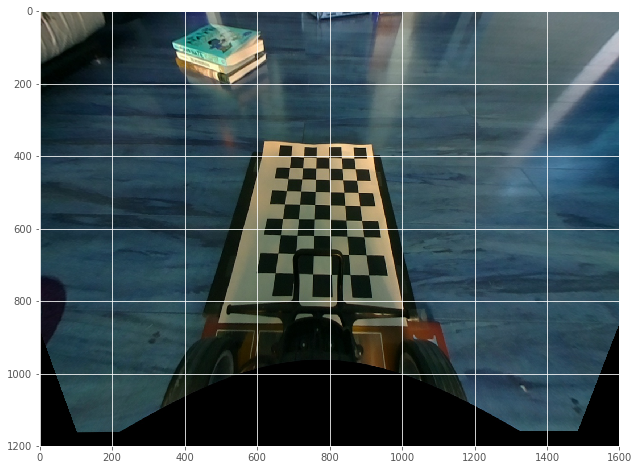

In [14]:
import numpy as np
import cv2

img = cv2.imread('../../donkeycar/_15degree1_undistort.jpg')

src = np.array([(710,476), (853,479), (902,729), (661,724)], dtype = "float32")
dst = np.array([(696, 403), (870, 407), (910, 729), (653, 724)], dtype = "float32")
M = cv2.getPerspectiveTransform(src, dst)
img = Image.open('../../donkeycar/_15degree1_undistort.jpg')
img_out = cv2.warpPerspective(np.asarray(img), M, (1600, 1200))
plt.imshow(img_out)